# Fine-tuning modelu tłumaczenia PL→EN z wykorzystaniem LoRA

W tym notebooku:
1. Instalujemy potrzebne paczki
2. Ładujemy dane (WMT16 PL–EN)
3. Tworzymy tokenizer i model
4. Konfigurujemy LoRA (PEFT)
5. Przygotowujemy dane (tokenizacja)
6. Definiujemy Trainer i trenujemy
7. Zapisujemy model i testujemy inferencję

#### 1. Instalacja pakietów

In [1]:
!pip install transformers datasets accelerate peft sacrebleu sentencepiece

#### 2. Importy i ustawienia globalne

In [2]:
import os
import time
from datasets import load_dataset
from transformers import (
    AutoTokenizer, AutoModelForSeq2SeqLM,
    Seq2SeqTrainingArguments, Seq2SeqTrainer,
    DataCollatorForSeq2Seq, pipeline
)
from peft import LoraConfig, get_peft_model
import sacrebleu

OUTPUT_DIR = "mt-pl-en-lora"

/Users/amika/python-global/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from datasets import get_dataset_config_names

print(get_dataset_config_names("opus100"))

['af-en', 'am-en', 'an-en', 'ar-de', 'ar-en', 'ar-fr', 'ar-nl', 'ar-ru', 'ar-zh', 'as-en', 'az-en', 'be-en', 'bg-en', 'bn-en', 'br-en', 'bs-en', 'ca-en', 'cs-en', 'cy-en', 'da-en', 'de-en', 'de-fr', 'de-nl', 'de-ru', 'de-zh', 'dz-en', 'el-en', 'en-eo', 'en-es', 'en-et', 'en-eu', 'en-fa', 'en-fi', 'en-fr', 'en-fy', 'en-ga', 'en-gd', 'en-gl', 'en-gu', 'en-ha', 'en-he', 'en-hi', 'en-hr', 'en-hu', 'en-hy', 'en-id', 'en-ig', 'en-is', 'en-it', 'en-ja', 'en-ka', 'en-kk', 'en-km', 'en-kn', 'en-ko', 'en-ku', 'en-ky', 'en-li', 'en-lt', 'en-lv', 'en-mg', 'en-mk', 'en-ml', 'en-mn', 'en-mr', 'en-ms', 'en-mt', 'en-my', 'en-nb', 'en-ne', 'en-nl', 'en-nn', 'en-no', 'en-oc', 'en-or', 'en-pa', 'en-pl', 'en-ps', 'en-pt', 'en-ro', 'en-ru', 'en-rw', 'en-se', 'en-sh', 'en-si', 'en-sk', 'en-sl', 'en-sq', 'en-sr', 'en-sv', 'en-ta', 'en-te', 'en-tg', 'en-th', 'en-tk', 'en-tr', 'en-tt', 'en-ug', 'en-uk', 'en-ur', 'en-uz', 'en-vi', 'en-wa', 'en-xh', 'en-yi', 'en-yo', 'en-zh', 'en-zu', 'fr-nl', 'fr-ru', 'fr-zh', 

#### 3. Ładowanie danych (subset OPUS100 en-pl)

In [4]:
from datasets import load_dataset

raw = load_dataset("opus100", "en-pl")

train_raw = raw["train"].shuffle(seed=42).select(range(20000))
val_raw = raw["validation"].shuffle(seed=42).select(range(2000))

print(f"Train samples: {len(train_raw)}, Validation samples: {len(val_raw)}")
print(train_raw[0]["translation"])

Train samples: 20000, Validation samples: 2000
{'en': "I'm sure you do.", 'pl': 'Zapewne tak.'}


#### 4. Tokenizer i bazowy model

In [5]:
MODEL_ID = "Helsinki-NLP/opus-mt-pl-en"
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
base_model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_ID)

translator = pipeline("translation", model=base_model, tokenizer=tokenizer)
print("Przykład:", translator("To jest test zdania."))

Device set to use mps:0


Przykład: [{'translation_text': 'This is a sentence test.'}]


#### 5. Konfiguracja LoRA (PEFT)

In [7]:
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="SEQ_2_SEQ_LM"
)
model = get_peft_model(base_model, lora_config)

adapter = model.active_adapter
conf = model.peft_config[adapter]
print("Aktywny adapter:", adapter)
print("Target modules:", conf.target_modules)

Aktywny adapter: default
Target modules: {'q_proj', 'v_proj'}


/Users/amika/python-global/lib/python3.12/site-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/Users/amika/python-global/lib/python3.12/site-packages/peft/tuners/tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


#### 6. Funkcja preprocessująca i tokenizacja

In [9]:
max_len = 128


def preprocess(batch):
    src_texts = [t["pl"] for t in batch["translation"]]
    tgt_texts = [t["en"] for t in batch["translation"]]

    model_inputs = tokenizer(
        src_texts,
        truncation=True,
        padding="max_length",
        max_length=max_len
    )

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            tgt_texts,
            truncation=True,
            padding="max_length",
            max_length=max_len
        ).input_ids

    model_inputs["labels"] = labels
    return model_inputs


train_ds = train_raw.map(
    preprocess,
    batched=True,
    remove_columns=train_raw.column_names
)
val_ds = val_raw.map(
    preprocess,
    batched=True,
    remove_columns=val_raw.column_names
)

print(train_ds)

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]/Users/amika/python-global/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:3959: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
Map: 100%|██████████| 2000/2000 [00:00<00:00, 9983.53 examples/s] 

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 20000
})


#### 7. DataCollator i metryki (BLEU)

In [10]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)


def compute_metrics(eval_pred):
    preds, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    bleu = sacrebleu.corpus_bleu(decoded_preds, [decoded_labels])
    return {"bleu": bleu.score}

In [16]:
training_args = Seq2SeqTrainingArguments(
    output_dir=OUTPUT_DIR,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    predict_with_generate=True,
    eval_strategy="steps",
    eval_steps=500,
    save_strategy="steps",
    save_steps=500,
    logging_steps=100,
    num_train_epochs=3,
    fp16=False,
    load_best_model_at_end=True,
    metric_for_best_model="bleu",
    greater_is_better=True,
)

#### 9. Inicjalizacja i uruchomienie Trainer

In [17]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()

/var/folders/z_/dq8r0xg94mxfzfpr1jmhv_740000gn/T/ipykernel_21716/74575465.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
No label_names provided for model class `PeftModelForSeq2SeqLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/Users/amika/python-global/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss,Validation Loss,Bleu
500,0.160400,0.196286,8.534518
1000,0.157200,0.194469,10.207711
1500,0.163000,0.193122,12.053509
2000,0.159600,0.192120,11.912978
2500,0.151100,0.191361,13.503544
3000,0.160900,0.190978,14.262612
3500,0.158000,0.190830,14.289325


/Users/amika/python-global/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/amika/python-global/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/amika/python-global/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/amika/python-global/lib/python3.12/site-packages/peft/utils/other.py:1110: UserWarning: Unable to fetch remote file due to the following error (ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: a692e804-

TrainOutput(global_step=3750, training_loss=0.2754562779744466, metrics={'train_runtime': 24722.0576, 'train_samples_per_second': 2.427, 'train_steps_per_second': 0.152, 'total_flos': 2047491440640000.0, 'train_loss': 0.2754562779744466, 'epoch': 3.0})

#### 10. Zapis finalnego modelu

In [18]:
model.save_pretrained(os.path.join(OUTPUT_DIR, "lora"))
tokenizer.save_pretrained(os.path.join(OUTPUT_DIR, "lora"))

('mt-pl-en-lora/lora/tokenizer_config.json',
 'mt-pl-en-lora/lora/special_tokens_map.json',
 'mt-pl-en-lora/lora/vocab.json',
 'mt-pl-en-lora/lora/source.spm',
 'mt-pl-en-lora/lora/target.spm',
 'mt-pl-en-lora/lora/added_tokens.json')

#### 11. Test inferencji na zapisanym modelu

In [19]:
from transformers import pipeline as _pipe

pipe = _pipe("translation", model=os.path.join(OUTPUT_DIR, "lora"), tokenizer=tokenizer)
print(pipe("Dzień dobry, to jest przykład testowy."))

Device set to use mps:0


[{'translation_text': 'Good morning, this is a test example.'}]


In [20]:
test_sentences = [
    "To jest test.",
    "Lubię jabłka.",
    "On poszedł do sklepu, ale zapomniał portfela.",
    "Jeżeli pada deszcz, weź parasol.",
    "Warszawa jest stolicą Polski i największym miastem kraju.",
    "Pomimo że spóźniliśmy się na pociąg, udało nam się złapać następny.",
    "Chociaż programista był zmęczony, kontynuował pracę nad projektem, aby dotrzymać terminu.",
    "Przyczyną awarii systemu była niezgodność wersji oprogramowania oraz niewłaściwe ustawienie parametrów.",
    "W obliczu nieuchronnej katastrofy, ludzie musieli szybko podjąć decyzję o ewakuacji.",
    "Ten złożony algorytm optymalizacyjny wykorzystuje gradienty skokowe i heurystyki, aby znaleźć globalne minimum funkcji w przestrzeni wielowymiarowej.",
    "Chcę napisać esej porównujący filozofię Platona z dialektyką Hegla i ich wpływ na współczesne myślenie polityczne.",
    "Mimo że życie potrafi być nieprzewidywalne, ważne jest, aby zachować spokój i elastyczność w podejmowaniu codziennych decyzji."
]

for sent in test_sentences:
    output = pipe(sent)[0]['translation_text']
    print(f"🔹 Źródło: {sent}")
    print(f"   Tłumaczenie: {output}\n")

🔹 Źródło: To jest test.
   Tłumaczenie: This is a test.

🔹 Źródło: Lubię jabłka.
   Tłumaczenie: I like apples.

🔹 Źródło: On poszedł do sklepu, ale zapomniał portfela.
   Tłumaczenie: He went to the store, but he forgot his wallet.

🔹 Źródło: Jeżeli pada deszcz, weź parasol.
   Tłumaczenie: If it rains, take an umbrella.

🔹 Źródło: Warszawa jest stolicą Polski i największym miastem kraju.
   Tłumaczenie: Warsaw is the capital of Poland and the largest city of the country.

🔹 Źródło: Pomimo że spóźniliśmy się na pociąg, udało nam się złapać następny.
   Tłumaczenie: Even though we missed the train, we managed to catch the next one.

🔹 Źródło: Chociaż programista był zmęczony, kontynuował pracę nad projektem, aby dotrzymać terminu.
   Tłumaczenie: Although the programmer was tired, he continued to work on the project to meet the deadline.

🔹 Źródło: Przyczyną awarii systemu była niezgodność wersji oprogramowania oraz niewłaściwe ustawienie parametrów.
   Tłumaczenie: The cause of the sy

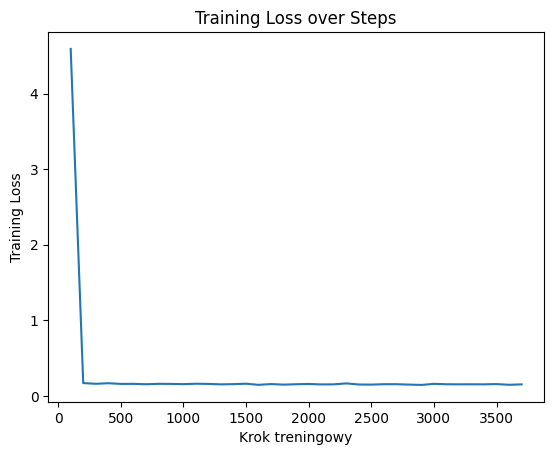

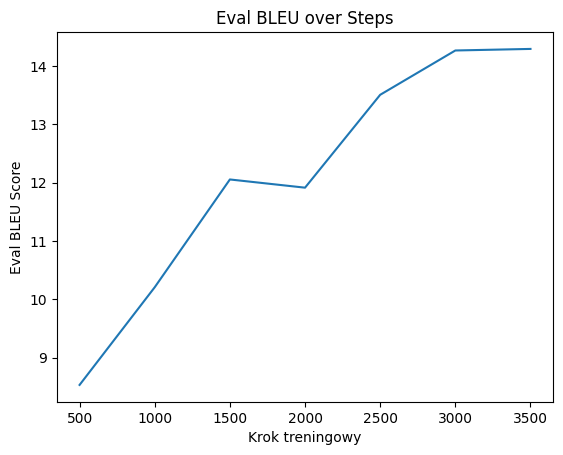

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

if 'trainer' not in globals():
    print("Proszę uruchomić wcześniej komórkę z definiowaniem i treningiem obiektu `trainer`, aby wygenerować wykresy.")
else:
    history = trainer.state.log_history
    df = pd.DataFrame(history)

    loss_df = df[['step', 'loss']].dropna()
    bleu_df = df[['step', 'eval_bleu']].dropna()

    plt.figure()
    plt.plot(loss_df['step'], loss_df['loss'])
    plt.xlabel('Krok treningowy')
    plt.ylabel('Training Loss')
    plt.title('Training Loss over Steps')
    plt.show()

    plt.figure()
    plt.plot(bleu_df['step'], bleu_df['eval_bleu'])
    plt.xlabel('Krok treningowy')
    plt.ylabel('Eval BLEU Score')
    plt.title('Eval BLEU over Steps')
    plt.show()

## Testy i eksperymenty z LoRA na różnych modelach
W poniższej sekcji przeprowadzimy kilka eksperymentów z różnymi modelami i konfiguracjami LoRA.

In [22]:
import os
import numpy as np
import sacrebleu
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    DataCollatorForSeq2Seq,
    pipeline,
)
from peft import LoraConfig, get_peft_model, PeftModel
import torch

RESULTS_DIR = "results_pl_en"
os.makedirs(RESULTS_DIR, exist_ok=True)

In [39]:
def prepare_datasets(train_size: int, val_size: int = 5000, max_len: int = 128):
    """
    Ładuje korpus OPUS100 en-pl,
    wybiera losowy subset train_size i subset walidacyjny do actual_val_size,
    tokenizuje do max_len.
    """
    raw = load_dataset("opus100", "en-pl")

    available_val = len(raw["validation"])
    actual_val_size = min(val_size, available_val)

    train_raw = raw["train"].shuffle(seed=42).select(range(train_size))
    val_raw = raw["validation"].shuffle(seed=42).select(range(actual_val_size))

    def preprocess(batch):
        pl_list = [example["pl"] for example in batch["translation"]]
        en_list = [example["en"] for example in batch["translation"]]

        in_tok = tokenizer(
            pl_list,
            truncation=True,
            padding="max_length",
            max_length=max_len
        )
        out_tok = tokenizer(
            en_list,
            truncation=True,
            padding="max_length",
            max_length=max_len
        )
        return {
            "input_ids": in_tok["input_ids"],
            "attention_mask": in_tok["attention_mask"],
            "labels": out_tok["input_ids"],
        }

    train_ds = train_raw.map(preprocess, batched=True, remove_columns=train_raw.column_names)
    val_ds = val_raw.map(preprocess, batched=True, remove_columns=val_raw.column_names)
    return train_ds, val_ds


def compute_metrics(eval_preds):
    preds, labels = eval_preds
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    bleu = sacrebleu.corpus_bleu(decoded_preds, [decoded_labels])
    return {"bleu": bleu.score}


def save_lora_adapter(model, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    model.save_pretrained(output_dir)

In [40]:
device = 0 if torch.cuda.is_available() else -1
print("Urządzenie:", "cuda" if device == 0 else "cpu")

Urządzenie: cpu


### Eksperyment z Helsinki NLP (20k próbek, 3 epoki, LoRA r=8, max_len=128)

In [41]:
config_1 = {
    "base_model_id": "Helsinki-NLP/opus-mt-pl-en",
    "train_size": 20000,
    "val_size": 2000,
    "num_epochs": 3,
    "lora_r": 8,
    "batch_size": 16,
    "learning_rate": 5e-5,
    "max_len": 128,
    "num_beams": 1,
}

In [42]:
exp_name_1 = (
    f"helsinki_"
    f"train{config_1['train_size'] // 1000}k_"
    f"ep{config_1['num_epochs']}_"
    f"r{config_1['lora_r']}_"
    f"len{config_1['max_len']}"
)

#### Tokenizer i LoRA model

In [43]:
tokenizer = AutoTokenizer.from_pretrained(config_1["base_model_id"])
base_model = AutoModelForSeq2SeqLM.from_pretrained(config_1["base_model_id"])

lora_config = LoraConfig(
    r=config_1["lora_r"],
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_2_SEQ_LM",
)
model = get_peft_model(base_model, lora_config)

#### Przygotowanie danych

In [44]:
train_ds, val_ds = prepare_datasets(
    train_size=config_1["train_size"],
    val_size=config_1["val_size"],
    max_len=config_1["max_len"],
)

Map: 100%|██████████| 2000/2000 [00:00<00:00, 9254.29 examples/s]


In [45]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, label_pad_token_id=-100)

In [46]:
output_dir_1 = os.path.join(RESULTS_DIR, exp_name_1)
os.makedirs(output_dir_1, exist_ok=True)

training_args_1 = Seq2SeqTrainingArguments(
    output_dir=output_dir_1,
    per_device_train_batch_size=config_1["batch_size"],
    per_device_eval_batch_size=config_1["batch_size"],
    predict_with_generate=True,
    eval_strategy="steps",
    eval_steps=500,
    save_strategy="steps",
    save_steps=500,
    logging_steps=100,
    num_train_epochs=config_1["num_epochs"],
    learning_rate=config_1["learning_rate"],
    warmup_steps=500,
    weight_decay=0.01,
    label_smoothing_factor=0.1,
    generation_max_length=config_1["max_len"],
    generation_num_beams=config_1["num_beams"],
    load_best_model_at_end=True,
    metric_for_best_model="bleu",
    greater_is_better=True,
)

#### Seq2SeqTrainer i trening

In [47]:
trainer_1 = Seq2SeqTrainer(
    model=model,
    args=training_args_1,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer_1.train()

/var/folders/z_/dq8r0xg94mxfzfpr1jmhv_740000gn/T/ipykernel_21716/185204296.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer_1 = Seq2SeqTrainer(
No label_names provided for model class `PeftModelForSeq2SeqLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/Users/amika/python-global/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.58.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss,Validation Loss,Bleu
500,2.112500,2.188936,29.233314
1000,2.001300,2.068457,21.946135
1500,1.981800,2.037692,18.228974
2000,1.952900,2.022043,18.390802
2500,1.943700,2.011264,17.132577
3000,1.957800,2.004875,16.229079
3500,1.943500,2.001432,16.149608


/Users/amika/python-global/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/amika/python-global/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/amika/python-global/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/amika/python-global/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/amika/python-global/lib/python3.12/si

TrainOutput(global_step=3750, training_loss=2.3701901835123698, metrics={'train_runtime': 2768.6303, 'train_samples_per_second': 21.671, 'train_steps_per_second': 1.354, 'total_flos': 2047491440640000.0, 'train_loss': 2.3701901835123698, 'epoch': 3.0})

In [52]:
best_bleu_1 = trainer_1.state.best_metric
print(f"{exp_name_1} → BEST BLEU: {best_bleu_1:.2f}")

helsinki_train20k_ep3_r8_len128 → BEST BLEU: 29.23


In [53]:
adapter_dir_1 = os.path.join(output_dir_1, "lora_adapter")
save_lora_adapter(model, adapter_dir_1)

### Eksperyment z Helsinki NLP (20k próbek, 7 epok, LoRA r=8, max_len=128)

In [54]:
config_2 = config_1.copy()
config_2["num_epochs"] = 7

In [55]:
exp_name_2 = (
    f"helsinki_"
    f"train{config_2['train_size'] // 1000}k_"
    f"ep{config_2['num_epochs']}_"
    f"r{config_2['lora_r']}_"
    f"len{config_2['max_len']}"
)

In [56]:
tokenizer = AutoTokenizer.from_pretrained(config_2["base_model_id"])
base_model = AutoModelForSeq2SeqLM.from_pretrained(config_2["base_model_id"])

lora_config = LoraConfig(
    r=config_2["lora_r"],
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_2_SEQ_LM",
)
model = get_peft_model(base_model, lora_config)

In [57]:
train_ds, val_ds = prepare_datasets(
    train_size=config_2["train_size"],
    val_size=config_2["val_size"],
    max_len=config_2["max_len"],
)

In [58]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, label_pad_token_id=-100)

In [59]:
output_dir_2 = os.path.join(RESULTS_DIR, exp_name_2)
os.makedirs(output_dir_2, exist_ok=True)

training_args_2 = Seq2SeqTrainingArguments(
    output_dir=output_dir_2,
    per_device_train_batch_size=config_2["batch_size"],
    per_device_eval_batch_size=config_2["batch_size"],
    predict_with_generate=True,
    eval_strategy="steps",
    eval_steps=500,
    save_strategy="steps",
    save_steps=500,
    logging_steps=100,
    num_train_epochs=config_2["num_epochs"],
    learning_rate=config_2["learning_rate"],
    warmup_steps=500,
    weight_decay=0.01,
    label_smoothing_factor=0.1,
    generation_max_length=config_2["max_len"],
    generation_num_beams=config_2["num_beams"],
    load_best_model_at_end=True,
    metric_for_best_model="bleu",
    greater_is_better=True,
)

In [60]:
trainer_2 = Seq2SeqTrainer(
    model=model,
    args=training_args_2,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer_2.train()

/var/folders/z_/dq8r0xg94mxfzfpr1jmhv_740000gn/T/ipykernel_21716/980042975.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer_2 = Seq2SeqTrainer(
No label_names provided for model class `PeftModelForSeq2SeqLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/Users/amika/python-global/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss,Validation Loss,Bleu
500,2.111300,2.186978,29.102469
1000,2.001000,2.067745,21.705677
1500,1.979100,2.033789,18.388672
2000,1.947300,2.014410,18.194986
2500,1.933800,1.999853,16.765346
3000,1.944300,1.987275,15.118164
3500,1.924900,1.978197,16.061137
4000,1.927900,1.971850,15.682335
4500,1.896700,1.966168,15.918435
5000,1.896900,1.961157,15.471418


/Users/amika/python-global/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/amika/python-global/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/amika/python-global/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/amika/python-global/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/amika/python-global/lib/python3.12/si

TrainOutput(global_step=8750, training_loss=2.092338405936105, metrics={'train_runtime': 6301.0639, 'train_samples_per_second': 22.218, 'train_steps_per_second': 1.389, 'total_flos': 4777480028160000.0, 'train_loss': 2.092338405936105, 'epoch': 7.0})

In [61]:
best_bleu_2 = trainer_2.state.best_metric
print(f"{exp_name_2} → BEST BLEU: {best_bleu_2:.2f}")

helsinki_train20k_ep7_r8_len128 → BEST BLEU: 29.10


In [62]:
adapter_dir_2 = os.path.join(output_dir_2, "lora_adapter")
save_lora_adapter(model, adapter_dir_2)

### Eksperyment z Helsinki NLP (100k próbek, 7 epok, LoRA r=8, max_len=128)

In [63]:
config_3 = config_1.copy()
config_3["train_size"] = 100000
config_3["num_epochs"] = 7

In [64]:
exp_name_3 = (
    f"helsinki_"
    f"train{config_3['train_size'] // 1000}k_"
    f"ep{config_3['num_epochs']}_"
    f"r{config_3['lora_r']}_"
    f"len{config_3['max_len']}"
)

In [65]:
tokenizer = AutoTokenizer.from_pretrained(config_3["base_model_id"])
base_model = AutoModelForSeq2SeqLM.from_pretrained(config_3["base_model_id"])

lora_config = LoraConfig(
    r=config_3["lora_r"],
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_2_SEQ_LM",
)
model = get_peft_model(base_model, lora_config)

In [66]:
train_ds, val_ds = prepare_datasets(
    train_size=config_3["train_size"],
    val_size=config_3["val_size"],
    max_len=config_3["max_len"],
)

Map: 100%|██████████| 100000/100000 [00:10<00:00, 9379.49 examples/s]


In [67]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, label_pad_token_id=-100)

In [68]:
output_dir_3 = os.path.join(RESULTS_DIR, exp_name_3)
os.makedirs(output_dir_3, exist_ok=True)

training_args_3 = Seq2SeqTrainingArguments(
    output_dir=output_dir_3,
    per_device_train_batch_size=config_3["batch_size"],
    per_device_eval_batch_size=config_3["batch_size"],
    predict_with_generate=True,
    eval_strategy="steps",
    eval_steps=500,
    save_strategy="steps",
    save_steps=500,
    logging_steps=100,
    num_train_epochs=config_3["num_epochs"],
    learning_rate=config_3["learning_rate"],
    warmup_steps=500,
    weight_decay=0.01,
    label_smoothing_factor=0.1,
    generation_max_length=config_3["max_len"],
    generation_num_beams=config_3["num_beams"],
    load_best_model_at_end=True,
    metric_for_best_model="bleu",
    greater_is_better=True,
)

In [69]:
trainer_3 = Seq2SeqTrainer(
    model=model,
    args=training_args_3,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer_3.train()

/var/folders/z_/dq8r0xg94mxfzfpr1jmhv_740000gn/T/ipykernel_21716/3476486030.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer_3 = Seq2SeqTrainer(
No label_names provided for model class `PeftModelForSeq2SeqLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/Users/amika/python-global/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss,Validation Loss,Bleu
500,2.121300,2.182435,29.073688
1000,1.999000,2.065768,21.645890
1500,1.949400,2.031718,19.361525
2000,1.975800,2.010228,17.772969
2500,1.919900,1.994683,17.842267
3000,1.905400,1.979528,16.212733
3500,1.901700,1.969926,16.304948
4000,1.888500,1.960451,15.428576
4500,1.901500,1.952791,15.680655
5000,1.889100,1.946117,15.773801


/Users/amika/python-global/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/amika/python-global/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/amika/python-global/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/amika/python-global/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/amika/python-global/lib/python3.12/si

TrainOutput(global_step=43750, training_loss=1.8814152512904576, metrics={'train_runtime': 30507.1638, 'train_samples_per_second': 22.945, 'train_steps_per_second': 1.434, 'total_flos': 2.38874001408e+16, 'train_loss': 1.8814152512904576, 'epoch': 7.0})

In [70]:
best_bleu_3 = trainer_3.state.best_metric
print(f"{exp_name_3} → BEST BLEU: {best_bleu_3:.2f}")

helsinki_train100k_ep7_r8_len128 → BEST BLEU: 29.07


In [71]:
adapter_dir_3 = os.path.join(output_dir_3, "lora_adapter")
save_lora_adapter(model, adapter_dir_3)

### Podsumowanie wyników eksperymentów

In [152]:
import pandas as pd

results_table = [
    {"experiment": exp_name_1, "BLEU": best_bleu_1},
    {"experiment": exp_name_2, "BLEU": best_bleu_2},
    {"experiment": exp_name_3, "BLEU": best_bleu_3},
]
df_results = pd.DataFrame(results_table)
df_results

,experiment,BLEU
0,helsinki_train20k_ep3_r8_len128,29.233314
1,helsinki_train20k_ep7_r8_len128,29.102469
2,helsinki_train100k_ep7_r8_len128,29.073688


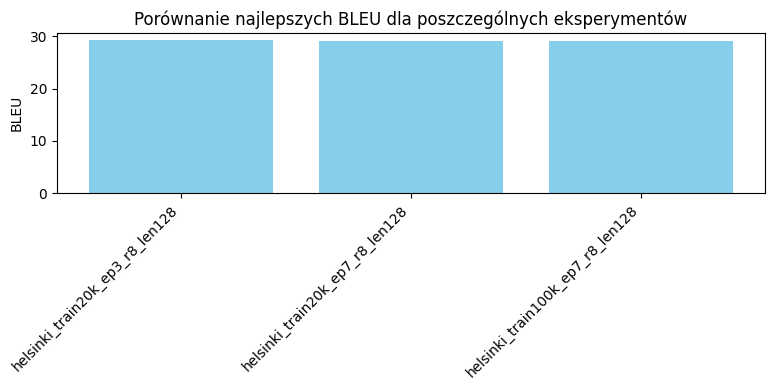

In [162]:
plt.figure(figsize=(8, 4))
plt.bar(df_results["experiment"], df_results["BLEU"], color="skyblue")
plt.xticks(rotation=45, ha="right")
plt.ylabel("BLEU")
plt.title("Porównanie najlepszych BLEU dla poszczególnych eksperymentów")
plt.tight_layout()
plt.show()

In [163]:
def extract_loss_history(trainer):
    """
    Z obiektu Trainer wyciąga listę słowników 'log_history',
    filtruje wpisy, które mają klucze 'loss' (trening) i 'eval_loss' (validation).
    Zwraca dwa DataFrame'y: jeden z loss, drugi z eval_loss.
    """
    history = trainer.state.log_history  # lista słowników

    train_entries = [entry for entry in history if "loss" in entry and "epoch" in entry]

    eval_entries = [entry for entry in history if "eval_loss" in entry]

    df_train = pd.DataFrame(train_entries)[["step", "epoch", "loss"]].dropna().reset_index(drop=True)
    df_eval = pd.DataFrame(eval_entries)[["step", "epoch", "eval_loss"]].dropna().reset_index(drop=True)
    return df_train, df_eval

train_hist_1, eval_hist_1 = extract_loss_history(trainer_1)
train_hist_2, eval_hist_2 = extract_loss_history(trainer_2)
train_hist_3, eval_hist_3 = extract_loss_history(trainer_3)

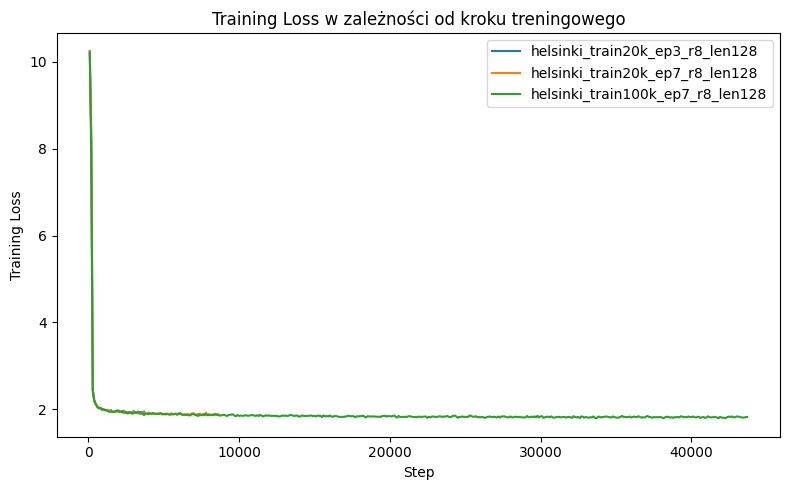

In [164]:
plt.figure(figsize=(8, 5))
plt.plot(train_hist_1["step"], train_hist_1["loss"], label=exp_name_1)
plt.plot(train_hist_2["step"], train_hist_2["loss"], label=exp_name_2)
plt.plot(train_hist_3["step"], train_hist_3["loss"], label=exp_name_3)
plt.xlabel("Step")
plt.ylabel("Training Loss")
plt.title("Training Loss w zależności od kroku treningowego")
plt.legend()
plt.tight_layout()
plt.show()

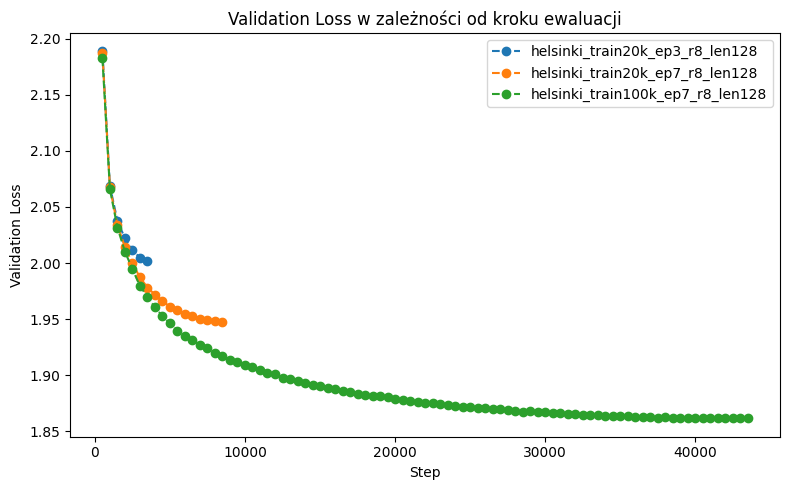

In [165]:
plt.figure(figsize=(8, 5))
plt.plot(eval_hist_1["step"], eval_hist_1["eval_loss"], marker="o", linestyle="--", label=exp_name_1)
plt.plot(eval_hist_2["step"], eval_hist_2["eval_loss"], marker="o", linestyle="--", label=exp_name_2)
plt.plot(eval_hist_3["step"], eval_hist_3["eval_loss"], marker="o", linestyle="--", label=exp_name_3)
plt.xlabel("Step")
plt.ylabel("Validation Loss")
plt.title("Validation Loss w zależności od kroku ewaluacji")
plt.legend()
plt.tight_layout()
plt.show()

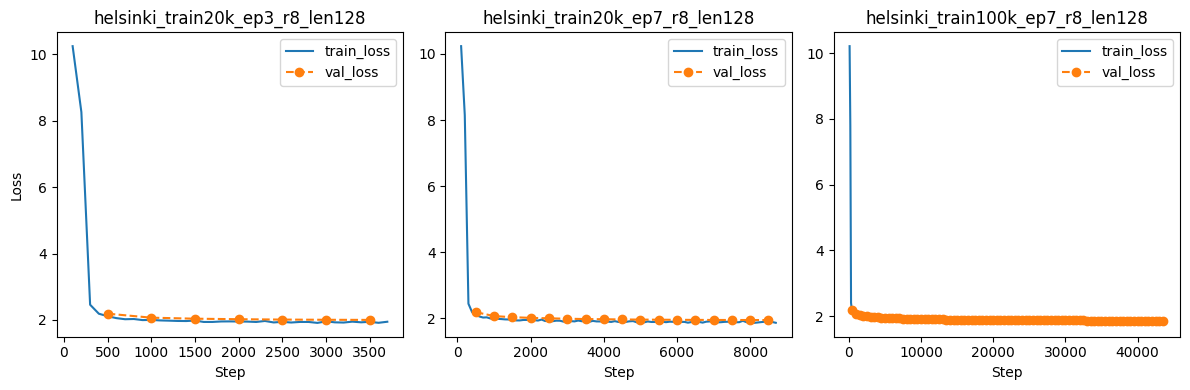

In [166]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(train_hist_1["step"], train_hist_1["loss"], label="train_loss", color="tab:blue")
plt.plot(eval_hist_1["step"], eval_hist_1["eval_loss"], label="val_loss", color="tab:orange", linestyle="--", marker="o")
plt.title(exp_name_1)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_hist_2["step"], train_hist_2["loss"], label="train_loss", color="tab:blue")
plt.plot(eval_hist_2["step"], eval_hist_2["eval_loss"], label="val_loss", color="tab:orange", linestyle="--", marker="o")
plt.title(exp_name_2)
plt.xlabel("Step")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(train_hist_3["step"], train_hist_3["loss"], label="train_loss", color="tab:blue")
plt.plot(eval_hist_3["step"], eval_hist_3["eval_loss"], label="val_loss", color="tab:orange", linestyle="--", marker="o")
plt.title(exp_name_3)
plt.xlabel("Step")
plt.legend()

plt.tight_layout()
plt.show()

Wykonaliśmy trzy główne eksperymenty z LoRA na modelu `Helsinki-NLP/opus-mt-pl-en`, różniące się głównie:
1. `helsinki_train20k_ep3_r8_len128` – 20 000 próbek, 3 epoki, r=8, max_len=128.
    - Najwyższe BLEU: ~29.23
    - Trend: zauważalny spadek training loss w kolejnych krokach, validation loss stabilizuje się w okolicy etapu 2k–3k.
2. `helsinki_train20k_ep7_r8_len128` – 20 000 próbek, 7 epok, r=8, max_len=128.
    - Najwyższe BLEU: ~29.10
    - Trend: dodatkowe epoki niewiele wnoszą, validation BLEU zaczyna spadać po etapie 4k, co może sugerować lekkie przeuczenie.
3. `helsinki_train100k_ep7_r8_len128` – 100 000 próbek, 7 epok, r=8, max_len=128.
    - Najwyższe BLEU: ~29.07
    - Trend: większa ilość danych spowodowała nieco wolniejszy spadek training loss, a validation loss osiągnął plateau nieco niżej niż w mniejszym zbiorze, ale najlepsze BLEU pozostaje porównywalne.

Na wykresach słupkowych widać, że wszystkie trzy konfiguracje osiągają bardzo zbliżone maksymalne BLEU (około 29).
Z kolei wykresy strat (loss) pokazują, że model trenujący na 100 k próbkach ma wolniejszą ścieżkę uczenia (loss spada wolniej), ale stabilizuje się na podobnym poziomie co wersje z 20 k.

Który model wybrać do dalszego użytku?
Wszystkie trzy eksperymenty osiągają bardzo podobne BLEU (~29). Z punktu widzenia wydajności (mniejszy zbiór + 3 epoki) najbardziej efektywny jest eksperyment `helsinki_train20k_ep3_r8_len128`: trenowanie trwa najszybciej, a BLEU jest minimalnie wyższe niż w pozostałych wariantach.

W przyszłości można zbadać dodatkowe warianty – np. inne modele bazowe (np. `facebook/m2m100_418M` czy `T5`), różne wartości `r` dla LoRA albo inne hiperparametry jak `learning_rate` i `lora_dropout`, jednak w naszych trzech próbkach różnice okazały się niewielkie.